# Lab6.2 Emotional classification with an LLM

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

Through this notebook, you will annotate a text with an LLM. We will use here a small open source model [Qwen version 3:1.7b](https://huggingface.co/Qwen).

You will read a conversation and send the utterances to the Ollama server to annotate each using instructions, so-called prompting.  The code for the annotator is given in **llm_annotator.py**. It is an Ollama client that sends a prompt request to a Ollama server server to get a response.

We assume you have already installed ```ollama``` locally and pulled the models that you need to your local machine. See lab1 for more instructions.

## 1. Instantiating the annotator

We create an instance of the LLMAnnotator after importing the code.

In [2]:
from llm_annotator import LLMAnnotator

To instantiate an LLMAnnotator, we can give it three parameters:

1. the name of the model
2. the set of labels
3. some examples for the few-shot learning
4. the maximum amount of context to be considered for each utterance

As a model, we use here ```qwen3:1.7b```. This model needs to be available in your local ```ollama``` server. You can also try another model if it fits in your memory. Note that the script for the LLMAnnotator has some specific code to get the answer from the response. The Qwen model outputs its thinking as well surrounded by ```<think>...</think>```. Using another model may imply adapting the processing of the response.


In [3]:
model='qwen3:1.7b'
### Labels to try
sentiment_labels = ["positive", "negative", "neutral"]
ekman_labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]
examples = [{"Input": "I love dogs", "Output": "joy"}, {"Input": "I hate cats", "Output": "disgust"}]
annotator = LLMAnnotator(model=model, labels=ekman_labels, examples=examples, max_context=5)

My instructions are: [{'role': 'system', 'content': 'You are an intelligent assistant.'}, {'role': 'system', 'content': 'You will receive utterances from a conversation as Input in JSON format.'}, {'role': 'system', 'content': 'You need to determine the emotion of the last utterance.'}, {'role': 'system', 'content': "Only use one of the following labels:['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']."}, {'role': 'system', 'content': 'Only determine the emotion of LAST utterance, use the preceding utterances as context.'}, {'role': 'system', 'content': 'Output the most appropriate label in JSON format.'}, {'role': 'system', 'content': 'Do not output anything else.'}, {'role': 'system', 'content': 'Here are a few examples:'}, {'role': 'user', 'content': 'I love dogs'}, {'role': 'system', 'content': 'joy'}, {'role': 'user', 'content': 'I hate cats'}, {'role': 'system', 'content': 'disgust'}]


We are now going to read the conversation that we created before with the LLM with our annotations and send these to the LLM to annotate.

In [4]:
import pandas as pd

annotation_file = "/Users/piek/Desktop/t-MA-HLT-introduction-2025/ma-hlt-labs/lab1.chat/annotation/chats_2024/adjudicated_annotations.json"

df = pd.read_json(annotation_file)
df.head()

,utterance,speaker,turn_id,Annotator,Gold,Votes,Annotators,Adjudication
0,Hi there! Going going well!,Raul,4,Pawel,neutral,"[neutral, joy, joy]","[Pawel, Leo Mylonadis, Matt]",joy
1,From hike? Do yo want to convince me you're a ...,Raul,6,Pawel,neutral,"[neutral, neutral, surprise]","[Pawel, Leo Mylonadis, Matt]",neutral
2,I hope that your dried llama food isn't anythi...,Raul,8,Pawel,disgust,"[disgust, disgust, neutral]","[Pawel, Leo Mylonadis, Matt]",disgust
3,Don't wink wink at me!,Raul,10,Pawel,anger,"[anger, anger, anger]","[Pawel, Leo Mylonadis, Matt]",anger
4,I think all the LLM hype is quite suspicious!,Raul,12,Pawel,anger,"[anger, fear, surprise]","[Pawel, Leo Mylonadis, Matt]",anger


From the Pandas dataframe, we select the "utterance" column as the list of utterances and take a subset for demonstration purposes. We call the ```annotate_conversation``` fucntion from the annotator to annotate the subset.

In [5]:
utterances = df["utterance"]
subset = 10
annotations = annotator.annotate_conversation(utterances[:subset])
print(annotations[:5])

Annotating a conversation with 10 utterances
Processed 5 in 96 seconds
Processed 5 turns in total out of 10
Processed 5 in 115 seconds
Processed 10 turns in total out of 10
[{'Input': 'Hi there! Going going well!', 'Output': 'joy'}, {'Input': "From hike? Do yo want to convince me you're a hiker? ", 'Output': 'neutral'}, {'Input': "I hope that your dried llama food isn't anything illicit! ", 'Output': 'neutral'}, {'Input': "Don't wink wink at me!", 'Output': 'anger'}, {'Input': 'I think all the LLM hype is quite suspicious!', 'Output': 'sadness'}]


First of all, note that a generative LLM is very slow, especially compared to an encoder model such as GO-BERT. An encoder represents the full texts in one go before generating the prediction for its classification head. A generative model does not use a classification head but needs to generate the next token at each step. So of it generates a response of ten tokens, it needs to represent the text ten times as well: once for each next token.

We could add the predictions from the LLM to the dataframe but LLMs do not always precisely follow the instructions e.g. "Output: Output:neutral". We therefore need to clean and filter the output. Specifically, we check if any of a Ekman label is a substring of the output and if so then take that value. If none of these is matched, we set the value to None.

In [6]:
llm_predicted_labels = []
for anno in annotations:
    ## By default the value is None
    llm_label = None
    if 'Output' in anno:
        prediction = anno['Output']
        for label in ekman_labels:
            if label in prediction:
                ### We found a valid label so we replace None by the label
                llm_label = label
    llm_predicted_labels.append(llm_label)
print('Clean list of predictions for the subset', llm_predicted_labels)

Clean list of predictions for the subset ['joy', 'neutral', 'neutral', 'anger', 'sadness', 'neutral', 'fear', 'disgust', 'sadness', 'sadness', 'anger', 'joy', 'sadness', 'sadness', 'fear', 'anger', 'sadness', 'sadness', 'neutral', 'anger']


We can now take the adjudicated annotations for the same subset as the gold labels and generate a classification report.

In [7]:
adjudicated_labels = list(df['Adjudication'])[:subset]
print('Adjudicated labels for the subset', adjudicated_labels)

print(len(llm_predicted_labels), len(adjudicated_labels))
for gold, predict in zip(adjudicated_labels, llm_predicted_labels):
    print(gold, predict)

Adjudicated labels for the subset ['joy', 'neutral', 'disgust', 'anger', 'anger', 'neutral', 'anger', 'sadness', 'sadness', 'neutral', 'anger', 'neutral', 'anger', 'neutral', 'neutral', 'anger', 'neutral', 'disgust', 'neutral', 'neutral']
20 20
joy joy
neutral neutral
disgust neutral
anger anger
anger sadness
neutral neutral
anger fear
sadness disgust
sadness sadness
neutral sadness
anger anger
neutral joy
anger sadness
neutral sadness
neutral fear
anger anger
neutral sadness
disgust sadness
neutral neutral
neutral anger


In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

label_set = set(adjudicated_labels+llm_predicted_labels)
report = classification_report(adjudicated_labels,llm_predicted_labels ,digits = 3, target_names=label_set)
print('LLM Ekman ----------------------------------------------------------------')

print(report)

LLM Ekman ----------------------------------------------------------------
              precision    recall  f1-score   support

     disgust      0.750     0.500     0.600         6
     sadness      0.000     0.000     0.000         2
        fear      0.000     0.000     0.000         0
         joy      0.500     1.000     0.667         1
       anger      0.750     0.333     0.462         9
     neutral      0.143     0.500     0.222         2

    accuracy                          0.400        20
   macro avg      0.357     0.389     0.325        20
weighted avg      0.602     0.400     0.443        20



/Users/piek/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piek/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piek/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

We can see that the results are not very good, which we could have guessed from the paired list of values: e.g. "sadness" is mostly assigned when it should not. 

Confusion matrix SVM
[[3 0 1 0 0 2]
 [0 0 0 0 1 1]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [1 0 1 1 3 3]
 [0 1 0 0 0 1]]


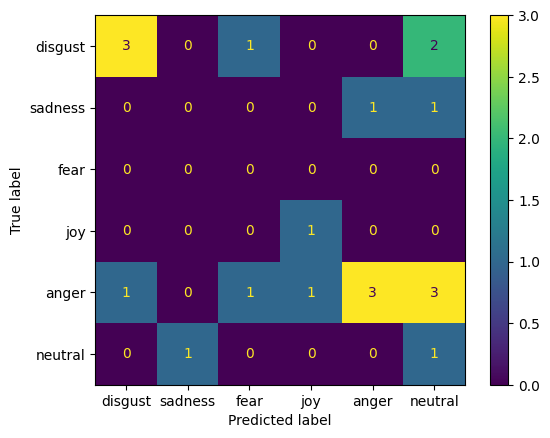

In [14]:
print('Confusion matrix SVM')
cf_matrix = confusion_matrix(adjudicated_labels,llm_predicted_labels)
print(cf_matrix)
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_set)
display.plot()

## End of notebook